In [1]:
# Standard libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
# PyTorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import json
from PIL import Image
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm

from DiffJPEG import DiffJPEG
from layers import gumbel_softmax
from helpers import create_default_qtables, return_class_name, return_class_accuracy, visualize

In [2]:
resnet = torchvision.models.resnet50(pretrained=False) 
#Just use pretrained = True if you can download the weights
resnet.load_state_dict(torch.load('../weights/resnet50.pth')) 
resnet.eval()
for param in resnet.parameters():
    param.requires_grad = False
print()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
f = open("class_lists/imagenet_class_index.json")
id_classname_json = json.load(f)
preprocess = transforms.Compose([
                            # transforms.CenterCrop((crop_size[1],crop_size[0])),
                            transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            ])
image = preprocess(Image.open("sample_imgs/panda.jpg"))
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
norm = transforms.Normalize(mean=mean, std=std)

3.333333333333333


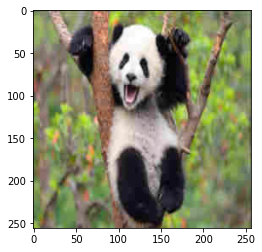

In [4]:
y_table, c_table = create_default_qtables()
JPEGCompress = DiffJPEG(image.shape[1], image.shape[2], differentiable=True, quality=15)
compressed_image = JPEGCompress(image.unsqueeze(0), y_table, c_table)[0]
plt.imshow(transforms.ToPILImage()(compressed_image))

In [5]:
with torch.no_grad():
    predictions = resnet(norm(image).unsqueeze(0))
    (target_class, target_dim) = return_class_name(id_classname_json, predictions)
    print(target_class)
    acc_of_original = return_class_accuracy(predictions, target_dim)
    
    predictions = resnet(norm(compressed_image).unsqueeze(0))
    acc_of_compressed = return_class_accuracy(predictions, target_dim)
    print(acc_of_original, acc_of_compressed)
    # predictied_class = return_class_name(predictions)[0]

giant_panda
65.0 52.0


In [6]:
train_dataset = torchvision.datasets.ImageFolder("../../data/imagenette2/train2", transform = preprocess)
train_dataset.class_to_idx = {
 'n01440764': 0,
 'n02102040': 217,
 'n02979186': 482,
 'n03000684': 491,
 'n03028079': 497,
 'n03394916': 566,
 'n03417042': 569,
 'n03425413': 571,
 'n03445777': 574,
 'n03888257': 701}
train_dataset.samples = train_dataset.make_dataset(train_dataset.root, 
                                                   train_dataset.class_to_idx, 
                                                   train_dataset.extensions, 
                                                   None)

val_dataset = torchvision.datasets.ImageFolder("../../data/imagenette2/train2", transform = preprocess)
val_dataset.class_to_idx = {
 'n01440764': 0,
 'n02102040': 217,
 'n02979186': 482,
 'n03000684': 491,
 'n03028079': 497,
 'n03394916': 566,
 'n03417042': 569,
 'n03425413': 571,
 'n03445777': 574,
 'n03888257': 701}
val_dataset.samples = val_dataset.make_dataset(val_dataset.root, 
                                               val_dataset.class_to_idx, 
                                               val_dataset.extensions, 
                                               None)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 256)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=16)

In [7]:
# pred = resnet(dataset[i][0].unsqueeze(0))
# idx = 9000
# print(return_class_name(resnet(dataset[idx][0].expand(3,-1,-1).unsqueeze(0))), dataset[idx][1])
# [print(return_class_name(resnet(i[0].expand(3,-1,-1).unsqueeze(0))), j) for i, j in dataset]

In [8]:
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor))
c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor))

In [9]:
y_table.shape

torch.Size([8, 8])

In [10]:
gumbel_softmax(y_table_1hot*10, 0.1, True).argmax(dim=2)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72],
        [ 11,  12,  13,  17,  22,  35,  64,  92],
        [ 10,  14,  16,  22,  37,  55,  78,  95],
        [ 16,  19,  24,  29,  56,  64,  87,  98],
        [ 24,  26,  40,  51,  68,  81, 103, 112],
        [ 40,  58,  57,  87, 109, 104, 121, 100],
        [ 51,  60,  69,  80, 103, 113, 120, 103],
        [ 61,  55,  56,  62,  77,  92, 101,  99]])

## Perturbing the Q-Tables to get better results

In [22]:
y_table, c_table = create_default_qtables()
# y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
# c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
y_table_1hot = torch.nn.functional.one_hot(torch.ones((8,8), dtype=torch.LongTensor.dtype), 
                                           num_classes=255).type(torch.FloatTensor) * 3
c_table_1hot = torch.nn.functional.one_hot(torch.ones((8,8), dtype=torch.LongTensor.dtype), 
                                           num_classes=255).type(torch.FloatTensor) * 3

y_table_1hot.requires_grad = True
c_table_1hot.requires_grad = True

optimizer = torch.optim.NAdam([
    y_table_1hot, 
    c_table_1hot
], lr=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, gamma = 0.9)

ones_table = torch.ones((8,8))
ones_table.requires_grad = False

categorical_values_table = torch.arange(255).reshape(1,-1) + 1 
# + 1 to avoid divide by zero errors when quantizing
categorical_values_table.requires_grad = False

# print(y_table.requires_grad)

loss = torch.nn.MSELoss()
qloss = torch.nn.MSELoss(reduction='mean')

# sanity check to ensure that gradients are flowing and changing the 1 hot y_table 
best_y_1hot = deepcopy(y_table_1hot) 

best_y_table = deepcopy(y_table)
best_c_table = deepcopy(c_table)
best_loss = np.inf

ori_train_acc = 0.0

initial_temperature = 0.3
temperature_anneal_rate = 0.05

# Hyperparam alpha to balance between maximizing Quantization and 
# minimizing euclidean dist against uncompressed logits
alpha = torch.tensor((1/10000000)) 
alpha.requires_grad=True

for epoch in range(100):
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0
    
    temperature = max(0.001, initial_temperature*np.exp(-temperature_anneal_rate*epoch))
    
    for (image, labels) in tqdm(train_loader):
        with torch.no_grad():
            ori_logits = resnet(norm(image))
            (target_class, target_dim) = return_class_name(id_classname_json, ori_logits[-1].unsqueeze(0))
            original_acc = return_class_accuracy(ori_logits[-1].unsqueeze(0), target_dim)
            if epoch == 0:
                ori_train_acc = ori_train_acc + (ori_logits.argmax(dim=1) == labels).sum()
                
        
        # y_table = gumbel_softmax(y_table_1hot.view(1, -1, 255), temperature, True) * categorical_values_table
        # c_table = gumbel_softmax(c_table_1hot.view(1, -1, 255), temperature, True) * categorical_values_table
        
        y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255), dim=2) * categorical_values_table
        c_table = torch.nn.functional.softmax(c_table_1hot.view(1, -1, 255), dim=2) * categorical_values_table
        
        y_table = y_table.sum(dim=2).reshape(8,8)
        c_table = c_table.sum(dim=2).reshape(8,8)

        # print(y_table)
        
        compressed_image = JPEGCompress(image, y_table, c_table)
        data = norm(compressed_image)
        logits = resnet(data)
        pred = logits.argmax(dim=1)
        
        loss_minimize = loss(logits, ori_logits) #we try to minimize this loss
        loss_maximize = (- qloss(y_table, ones_table) - qloss(c_table, ones_table))
        total_loss = (1-alpha)*loss_minimize + (alpha)* loss_maximize #total loss to be optimized

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # print((y_table_1hot == best_y_1hot).all())
        
        running_train_loss = running_train_loss + total_loss.detach().cpu() * image.shape[0]
        running_train_acc = running_train_acc + (pred == labels).sum()
    lr_scheduler.step()
            
    if running_train_loss/len(train_dataset) < best_loss:
        best_y_table = y_table
        best_c_table = c_table
        best_loss = running_train_loss/len(train_dataset)
        torch.save({"y_table" : y_table,
                   "c_table" : c_table,
                    "optimizer" : optimizer.state_dict(),
                   }, "best_ckpt.tar")
    
    if epoch == 0 :
        ori_train_acc = ori_train_acc / len(train_dataset)
        
    print("epoch {0}, training_loss: {1}, training_acc: {2}, ori_train_acc: {3}, logit loss: {4}, q table loss: {5}".format(
        epoch, 
        round(running_train_loss.item()/len(train_dataset), 5), 
        round(running_train_acc.item()/len(train_dataset)*100, 2),
        round(ori_train_acc.item()*100, 2),
        round(loss_minimize.item(), 5), 
        round(loss_maximize.item(), 5)
    ))
        

100%|██████████| 1/1 [00:18<00:00, 18.45s/it]


epoch 0, training_loss: 5.41613, training_acc: 0.0, ori_train_acc: 82.86, logit loss: 5.41893, q table loss: -27954.87305


100%|██████████| 1/1 [00:15<00:00, 15.97s/it]


epoch 1, training_loss: 5.31345, training_acc: 0.0, ori_train_acc: 82.86, logit loss: 5.31635, q table loss: -29001.48047


100%|██████████| 1/1 [00:15<00:00, 15.31s/it]


epoch 2, training_loss: 5.26368, training_acc: 0.0, ori_train_acc: 82.86, logit loss: 5.26669, q table loss: -30081.02344


100%|██████████| 1/1 [00:15<00:00, 15.93s/it]


epoch 3, training_loss: 5.1466, training_acc: 0.0, ori_train_acc: 82.86, logit loss: 5.1497, q table loss: -30949.75977


100%|██████████| 1/1 [00:15<00:00, 15.46s/it]


epoch 4, training_loss: 5.04934, training_acc: 1.43, ori_train_acc: 82.86, logit loss: 5.05252, q table loss: -31807.20703


100%|██████████| 1/1 [00:16<00:00, 16.11s/it]


epoch 5, training_loss: 4.92466, training_acc: 0.0, ori_train_acc: 82.86, logit loss: 4.92794, q table loss: -32797.99219


100%|██████████| 1/1 [00:14<00:00, 14.60s/it]


epoch 6, training_loss: 4.80662, training_acc: 1.43, ori_train_acc: 82.86, logit loss: 4.81001, q table loss: -33894.03906


100%|██████████| 1/1 [00:15<00:00, 15.45s/it]


epoch 7, training_loss: 4.75548, training_acc: 7.14, ori_train_acc: 82.86, logit loss: 4.75899, q table loss: -35041.91016


100%|██████████| 1/1 [00:14<00:00, 14.64s/it]


epoch 8, training_loss: 4.5665, training_acc: 10.0, ori_train_acc: 82.86, logit loss: 4.57012, q table loss: -36244.87891


100%|██████████| 1/1 [00:15<00:00, 15.10s/it]


epoch 9, training_loss: 4.45793, training_acc: 10.0, ori_train_acc: 82.86, logit loss: 4.46168, q table loss: -37494.46094


100%|██████████| 1/1 [00:16<00:00, 16.41s/it]


epoch 10, training_loss: 4.36673, training_acc: 10.0, ori_train_acc: 82.86, logit loss: 4.37061, q table loss: -38804.04688


100%|██████████| 1/1 [00:15<00:00, 15.18s/it]


epoch 11, training_loss: 4.37998, training_acc: 14.29, ori_train_acc: 82.86, logit loss: 4.38398, q table loss: -39973.66406


100%|██████████| 1/1 [00:15<00:00, 15.10s/it]


epoch 12, training_loss: 4.27819, training_acc: 15.71, ori_train_acc: 82.86, logit loss: 4.2823, q table loss: -41113.71875


100%|██████████| 1/1 [00:16<00:00, 16.81s/it]


epoch 13, training_loss: 4.10145, training_acc: 17.14, ori_train_acc: 82.86, logit loss: 4.10567, q table loss: -42220.34766


100%|██████████| 1/1 [00:14<00:00, 14.90s/it]


epoch 14, training_loss: 3.95259, training_acc: 25.71, ori_train_acc: 82.86, logit loss: 3.95694, q table loss: -43472.95312


100%|██████████| 1/1 [00:16<00:00, 16.20s/it]


epoch 15, training_loss: 3.86698, training_acc: 28.57, ori_train_acc: 82.86, logit loss: 3.87145, q table loss: -44679.46875


100%|██████████| 1/1 [00:15<00:00, 15.80s/it]


epoch 16, training_loss: 3.84353, training_acc: 27.14, ori_train_acc: 82.86, logit loss: 3.84812, q table loss: -45970.03906


100%|██████████| 1/1 [00:14<00:00, 14.89s/it]


epoch 17, training_loss: 3.68061, training_acc: 28.57, ori_train_acc: 82.86, logit loss: 3.68533, q table loss: -47228.21094


100%|██████████| 1/1 [00:14<00:00, 14.50s/it]


epoch 18, training_loss: 3.60939, training_acc: 31.43, ori_train_acc: 82.86, logit loss: 3.61425, q table loss: -48558.37109


100%|██████████| 1/1 [00:15<00:00, 15.29s/it]


epoch 19, training_loss: 3.53154, training_acc: 37.14, ori_train_acc: 82.86, logit loss: 3.53651, q table loss: -49691.36328


100%|██████████| 1/1 [00:14<00:00, 14.80s/it]


epoch 20, training_loss: 3.37292, training_acc: 38.57, ori_train_acc: 82.86, logit loss: 3.378, q table loss: -50758.67188


100%|██████████| 1/1 [00:15<00:00, 15.90s/it]


epoch 21, training_loss: 3.31705, training_acc: 38.57, ori_train_acc: 82.86, logit loss: 3.32224, q table loss: -51938.70312


100%|██████████| 1/1 [00:17<00:00, 17.32s/it]


epoch 22, training_loss: 3.32394, training_acc: 37.14, ori_train_acc: 82.86, logit loss: 3.32925, q table loss: -53063.75781


100%|██████████| 1/1 [00:16<00:00, 16.12s/it]


epoch 23, training_loss: 3.30821, training_acc: 32.86, ori_train_acc: 82.86, logit loss: 3.31363, q table loss: -54170.10547


100%|██████████| 1/1 [00:15<00:00, 15.68s/it]


epoch 24, training_loss: 3.2684, training_acc: 37.14, ori_train_acc: 82.86, logit loss: 3.27392, q table loss: -55206.25391


100%|██████████| 1/1 [00:14<00:00, 14.81s/it]


epoch 25, training_loss: 3.19768, training_acc: 38.57, ori_train_acc: 82.86, logit loss: 3.20331, q table loss: -56240.9375


100%|██████████| 1/1 [00:13<00:00, 13.51s/it]


epoch 26, training_loss: 3.18207, training_acc: 40.0, ori_train_acc: 82.86, logit loss: 3.1878, q table loss: -57215.40234


100%|██████████| 1/1 [00:14<00:00, 14.53s/it]


epoch 27, training_loss: 3.16915, training_acc: 41.43, ori_train_acc: 82.86, logit loss: 3.17496, q table loss: -58108.94531


100%|██████████| 1/1 [00:14<00:00, 14.57s/it]


epoch 28, training_loss: 3.11345, training_acc: 42.86, ori_train_acc: 82.86, logit loss: 3.11936, q table loss: -59050.45312


100%|██████████| 1/1 [00:16<00:00, 16.10s/it]


epoch 29, training_loss: 3.09046, training_acc: 41.43, ori_train_acc: 82.86, logit loss: 3.09645, q table loss: -59867.26172


100%|██████████| 1/1 [00:15<00:00, 15.81s/it]


epoch 30, training_loss: 3.05101, training_acc: 44.29, ori_train_acc: 82.86, logit loss: 3.05709, q table loss: -60718.35547


100%|██████████| 1/1 [00:16<00:00, 16.19s/it]


epoch 31, training_loss: 2.98646, training_acc: 42.86, ori_train_acc: 82.86, logit loss: 2.99261, q table loss: -61530.02344


100%|██████████| 1/1 [00:13<00:00, 13.29s/it]


epoch 32, training_loss: 2.97363, training_acc: 42.86, ori_train_acc: 82.86, logit loss: 2.97986, q table loss: -62287.70312


100%|██████████| 1/1 [00:13<00:00, 13.60s/it]


epoch 33, training_loss: 2.92634, training_acc: 42.86, ori_train_acc: 82.86, logit loss: 2.93264, q table loss: -63001.39062


100%|██████████| 1/1 [00:13<00:00, 13.01s/it]


epoch 34, training_loss: 2.82846, training_acc: 42.86, ori_train_acc: 82.86, logit loss: 2.83483, q table loss: -63714.32031


100%|██████████| 1/1 [00:13<00:00, 13.19s/it]


epoch 35, training_loss: 2.70189, training_acc: 45.71, ori_train_acc: 82.86, logit loss: 2.70833, q table loss: -64407.18359


100%|██████████| 1/1 [00:13<00:00, 13.29s/it]


epoch 36, training_loss: 2.71436, training_acc: 48.57, ori_train_acc: 82.86, logit loss: 2.72087, q table loss: -65114.58594


100%|██████████| 1/1 [00:13<00:00, 13.92s/it]


epoch 37, training_loss: 2.63233, training_acc: 50.0, ori_train_acc: 82.86, logit loss: 2.63891, q table loss: -65714.875


100%|██████████| 1/1 [00:14<00:00, 14.47s/it]


epoch 38, training_loss: 2.65349, training_acc: 48.57, ori_train_acc: 82.86, logit loss: 2.66012, q table loss: -66360.54688


100%|██████████| 1/1 [00:14<00:00, 14.40s/it]


epoch 39, training_loss: 2.6149, training_acc: 55.71, ori_train_acc: 82.86, logit loss: 2.6216, q table loss: -66962.40625


100%|██████████| 1/1 [00:14<00:00, 14.43s/it]


epoch 40, training_loss: 2.54117, training_acc: 55.71, ori_train_acc: 82.86, logit loss: 2.54792, q table loss: -67513.92188


100%|██████████| 1/1 [00:13<00:00, 13.99s/it]


epoch 41, training_loss: 2.47308, training_acc: 58.57, ori_train_acc: 82.86, logit loss: 2.47989, q table loss: -68036.9375


100%|██████████| 1/1 [00:14<00:00, 14.18s/it]


epoch 42, training_loss: 2.34608, training_acc: 58.57, ori_train_acc: 82.86, logit loss: 2.35293, q table loss: -68540.03906


100%|██████████| 1/1 [00:13<00:00, 13.50s/it]


epoch 43, training_loss: 2.28287, training_acc: 55.71, ori_train_acc: 82.86, logit loss: 2.28977, q table loss: -68973.42969


100%|██████████| 1/1 [00:14<00:00, 14.59s/it]


epoch 44, training_loss: 2.25738, training_acc: 57.14, ori_train_acc: 82.86, logit loss: 2.26433, q table loss: -69427.89062


100%|██████████| 1/1 [00:17<00:00, 17.11s/it]


epoch 45, training_loss: 2.19685, training_acc: 57.14, ori_train_acc: 82.86, logit loss: 2.20384, q table loss: -69864.99219


100%|██████████| 1/1 [00:16<00:00, 16.82s/it]


epoch 46, training_loss: 2.17589, training_acc: 60.0, ori_train_acc: 82.86, logit loss: 2.18292, q table loss: -70314.71875


100%|██████████| 1/1 [00:17<00:00, 17.64s/it]


epoch 47, training_loss: 2.16661, training_acc: 60.0, ori_train_acc: 82.86, logit loss: 2.17368, q table loss: -70656.19531


100%|██████████| 1/1 [00:14<00:00, 14.75s/it]


epoch 48, training_loss: 2.11763, training_acc: 61.43, ori_train_acc: 82.86, logit loss: 2.12473, q table loss: -70992.875


100%|██████████| 1/1 [00:13<00:00, 13.90s/it]


epoch 49, training_loss: 2.06963, training_acc: 62.86, ori_train_acc: 82.86, logit loss: 2.07676, q table loss: -71307.20312


100%|██████████| 1/1 [00:13<00:00, 13.97s/it]


epoch 50, training_loss: 2.06064, training_acc: 60.0, ori_train_acc: 82.86, logit loss: 2.06781, q table loss: -71681.375


100%|██████████| 1/1 [00:12<00:00, 12.72s/it]


epoch 51, training_loss: 2.00712, training_acc: 64.29, ori_train_acc: 82.86, logit loss: 2.01432, q table loss: -72029.375


100%|██████████| 1/1 [00:13<00:00, 13.10s/it]


epoch 52, training_loss: 1.92598, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.93321, q table loss: -72367.95312


100%|██████████| 1/1 [00:14<00:00, 14.09s/it]


epoch 53, training_loss: 1.90061, training_acc: 65.71, ori_train_acc: 82.86, logit loss: 1.90787, q table loss: -72684.54688


100%|██████████| 1/1 [00:13<00:00, 13.39s/it]


epoch 54, training_loss: 1.91946, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.92675, q table loss: -72975.64062


100%|██████████| 1/1 [00:14<00:00, 14.29s/it]


epoch 55, training_loss: 1.87443, training_acc: 64.29, ori_train_acc: 82.86, logit loss: 1.88176, q table loss: -73269.35938


100%|██████████| 1/1 [00:13<00:00, 13.71s/it]


epoch 56, training_loss: 1.81324, training_acc: 65.71, ori_train_acc: 82.86, logit loss: 1.8206, q table loss: -73565.97656


100%|██████████| 1/1 [00:13<00:00, 13.38s/it]


epoch 57, training_loss: 1.7784, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.78579, q table loss: -73868.64062


100%|██████████| 1/1 [00:12<00:00, 12.69s/it]


epoch 58, training_loss: 1.76402, training_acc: 65.71, ori_train_acc: 82.86, logit loss: 1.77144, q table loss: -74159.51562


100%|██████████| 1/1 [00:13<00:00, 13.22s/it]


epoch 59, training_loss: 1.75394, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.76139, q table loss: -74429.25781


100%|██████████| 1/1 [00:13<00:00, 13.68s/it]


epoch 60, training_loss: 1.741, training_acc: 65.71, ori_train_acc: 82.86, logit loss: 1.74847, q table loss: -74673.99219


100%|██████████| 1/1 [00:13<00:00, 13.10s/it]


epoch 61, training_loss: 1.74222, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.74971, q table loss: -74928.92969


100%|██████████| 1/1 [00:13<00:00, 13.41s/it]


epoch 62, training_loss: 1.71075, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.71826, q table loss: -75121.0625


100%|██████████| 1/1 [00:12<00:00, 12.20s/it]


epoch 63, training_loss: 1.71489, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.72243, q table loss: -75365.76562


100%|██████████| 1/1 [00:13<00:00, 13.49s/it]


epoch 64, training_loss: 1.71058, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.71813, q table loss: -75585.61719


100%|██████████| 1/1 [00:14<00:00, 14.32s/it]


epoch 65, training_loss: 1.72817, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.73575, q table loss: -75811.07812


100%|██████████| 1/1 [00:13<00:00, 13.69s/it]


epoch 66, training_loss: 1.68115, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.68875, q table loss: -76022.60156


100%|██████████| 1/1 [00:13<00:00, 13.18s/it]


epoch 67, training_loss: 1.709, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.71662, q table loss: -76214.625


100%|██████████| 1/1 [00:12<00:00, 12.79s/it]


epoch 68, training_loss: 1.69031, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.69795, q table loss: -76413.98438


100%|██████████| 1/1 [00:12<00:00, 12.93s/it]


epoch 69, training_loss: 1.68406, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.69172, q table loss: -76593.09375


100%|██████████| 1/1 [00:12<00:00, 12.79s/it]


epoch 70, training_loss: 1.67475, training_acc: 65.71, ori_train_acc: 82.86, logit loss: 1.68243, q table loss: -76740.28125


100%|██████████| 1/1 [00:13<00:00, 13.60s/it]


epoch 71, training_loss: 1.64992, training_acc: 71.43, ori_train_acc: 82.86, logit loss: 1.6576, q table loss: -76875.89844


100%|██████████| 1/1 [00:13<00:00, 13.50s/it]


epoch 72, training_loss: 1.65388, training_acc: 71.43, ori_train_acc: 82.86, logit loss: 1.66158, q table loss: -76993.14062


100%|██████████| 1/1 [00:13<00:00, 13.27s/it]


epoch 73, training_loss: 1.65692, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.66463, q table loss: -77114.21875


100%|██████████| 1/1 [00:13<00:00, 13.30s/it]


epoch 74, training_loss: 1.64249, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.65021, q table loss: -77240.73438


100%|██████████| 1/1 [00:14<00:00, 14.62s/it]


epoch 75, training_loss: 1.62051, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.62825, q table loss: -77345.79688


100%|██████████| 1/1 [00:14<00:00, 14.01s/it]


epoch 76, training_loss: 1.60409, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.61183, q table loss: -77482.84375


100%|██████████| 1/1 [00:13<00:00, 13.42s/it]


epoch 77, training_loss: 1.59113, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.59889, q table loss: -77599.15625


100%|██████████| 1/1 [00:13<00:00, 13.38s/it]


epoch 78, training_loss: 1.56045, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.56822, q table loss: -77670.24219


100%|██████████| 1/1 [00:13<00:00, 13.52s/it]


epoch 79, training_loss: 1.5638, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.57157, q table loss: -77727.29688


100%|██████████| 1/1 [00:13<00:00, 13.80s/it]


epoch 80, training_loss: 1.55128, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.55907, q table loss: -77868.41406


100%|██████████| 1/1 [00:13<00:00, 13.91s/it]


epoch 81, training_loss: 1.5526, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.5604, q table loss: -77950.26562


100%|██████████| 1/1 [00:13<00:00, 13.98s/it]


epoch 82, training_loss: 1.53347, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.54127, q table loss: -78047.82812


100%|██████████| 1/1 [00:13<00:00, 13.30s/it]


epoch 83, training_loss: 1.51155, training_acc: 67.14, ori_train_acc: 82.86, logit loss: 1.51936, q table loss: -78130.46094


100%|██████████| 1/1 [00:14<00:00, 14.10s/it]


epoch 84, training_loss: 1.51576, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.52358, q table loss: -78254.57812


100%|██████████| 1/1 [00:13<00:00, 13.91s/it]


epoch 85, training_loss: 1.52154, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.52937, q table loss: -78355.625


100%|██████████| 1/1 [00:13<00:00, 13.48s/it]


epoch 86, training_loss: 1.48766, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.4955, q table loss: -78409.6875


100%|██████████| 1/1 [00:14<00:00, 14.20s/it]


epoch 87, training_loss: 1.48829, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.49614, q table loss: -78501.15625


100%|██████████| 1/1 [00:14<00:00, 14.12s/it]


epoch 88, training_loss: 1.48608, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.49394, q table loss: -78560.00781


100%|██████████| 1/1 [00:13<00:00, 13.92s/it]


epoch 89, training_loss: 1.46162, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.46949, q table loss: -78621.625


100%|██████████| 1/1 [00:13<00:00, 13.59s/it]


epoch 90, training_loss: 1.46195, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.46981, q table loss: -78664.34375


100%|██████████| 1/1 [00:14<00:00, 14.01s/it]


epoch 91, training_loss: 1.44346, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.45134, q table loss: -78728.5


100%|██████████| 1/1 [00:13<00:00, 13.27s/it]


epoch 92, training_loss: 1.42993, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.43782, q table loss: -78810.24219


100%|██████████| 1/1 [00:13<00:00, 13.90s/it]


epoch 93, training_loss: 1.42242, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.43031, q table loss: -78873.51562


100%|██████████| 1/1 [00:13<00:00, 13.80s/it]


epoch 94, training_loss: 1.44103, training_acc: 68.57, ori_train_acc: 82.86, logit loss: 1.44892, q table loss: -78932.67188


100%|██████████| 1/1 [00:13<00:00, 13.73s/it]


epoch 95, training_loss: 1.42447, training_acc: 70.0, ori_train_acc: 82.86, logit loss: 1.43237, q table loss: -78979.70312


100%|██████████| 1/1 [00:14<00:00, 14.20s/it]


epoch 96, training_loss: 1.41362, training_acc: 71.43, ori_train_acc: 82.86, logit loss: 1.42152, q table loss: -79042.14062


100%|██████████| 1/1 [00:13<00:00, 13.51s/it]


epoch 97, training_loss: 1.41726, training_acc: 71.43, ori_train_acc: 82.86, logit loss: 1.42517, q table loss: -79090.125


100%|██████████| 1/1 [00:14<00:00, 14.11s/it]


epoch 98, training_loss: 1.40792, training_acc: 72.86, ori_train_acc: 82.86, logit loss: 1.41583, q table loss: -79121.66406


100%|██████████| 1/1 [00:13<00:00, 13.67s/it]

epoch 99, training_loss: 1.42047, training_acc: 71.43, ori_train_acc: 82.86, logit loss: 1.42838, q table loss: -79143.57812


In [33]:
temperature

0.0021250226787156356

In [27]:
# Calculate accuracy if y_table and c_table were integers
y_table = y_table_1hot.argmax(dim=2)+1
c_table = c_table_1hot.argmax(dim=2)+1

train_acc = 0
for (image, labels) in tqdm(train_loader):
    with torch.no_grad():
        compressed_image = JPEGCompress(image, y_table, c_table)
        logits = resnet(norm(compressed_image))
        (target_class, target_dim) = return_class_name(id_classname_json, logits[-1].unsqueeze(0))
        acc = return_class_accuracy(logits[-1].unsqueeze(0), target_dim)
        train_acc = train_acc + (logits.argmax(dim=1) == labels).sum()

print(train_acc/len(train_dataset))

100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

tensor(0.7857)


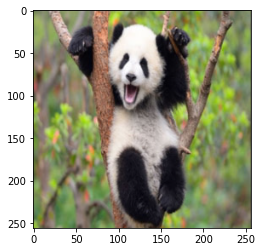

In [41]:
img = preprocess(Image.open("sample_imgs/panda.jpg"))
compressed_image = JPEGCompress(img.unsqueeze(0), y_table, c_table)[0]
# plt.figure(0, figsize=(20,20))
plt.imshow(transforms.ToPILImage()(compressed_image))

In [73]:
# check file size
import os
root = r"../../data/imagenette2/train2"
total_size_ori = 0

for folder in os.listdir(root):
    for file in os.listdir(os.path.join(root, folder)):
        total_size_ori += os.stat(os.path.join(root, folder, file)).st_size
        
print("total size originally:", total_size_ori)

qtable = {0: y_table.flatten().tolist(), 1: c_table.flatten().tolist()}
f_buffer = BytesIO()
total_size_aft = 0

for folder in os.listdir(root):
    for file in os.listdir(os.path.join(root, folder)):
        im.save(f_buffer, 'JPEG', qtables=qtable)
        total_size_aft += f_buffer.getbuffer().nbytes
        f_buffer.seek(0)
        f_buffer.truncate(0)

print("total size after:", total_size_aft)
print("compression_ratio:", round(total_size_aft/float(total_size_ori), 2))

total size originally: 6633823
total size after: 8333640
compression_ratio: 1.26


In [62]:
from io  import BytesIO
im = Image.open("sample_imgs/panda.jpg")
qtable = {0: y_table.flatten().tolist(), 1: c_table.flatten().tolist()}
# f_buffer = BytesIO()
im.save(f_buffer, 'JPEG', qtables=qtable)

In [55]:

im = Image.open("test.jpg")
print(np.array(im.quantization[0]).reshape(8,8), "\n", np.array(im.quantization[1]).reshape(8,8))

[[  2   1   2   2   1   1   2   2]
 [  2   2   2   2   2   2   2 255]
 [  2   2   2   2   2   2 255 255]
 [  2   2   2   2   2 255 255 255]
 [  2   2   2   2   2 255 255 255]
 [  2   2   2   2   2   2 255 255]
 [  2   2 255   2 255 255 255 255]
 [  2 255 255 255 255 255 255 255]] 
 [[  2   2   2 255 255 255 255 255]
 [  2   2   2 255 255 255 255 255]
 [  2   2 255 255 255 255 255 255]
 [  2 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255]]


In [65]:
f_buffer.getbuffer().nbytes

0

In [66]:
f_buffer.seek(0)
f_buffer.truncate(0)

0

In [58]:
import os
print(os.stat('sample_imgs/panda.jpg').st_size, os.stat('test.jpg').st_size)

69691 119052


In [ ]:
def extract_qtable(path):
    with Image.open(path) as im:
        qtable = im.quantization
    return {int(k): list(v) for k, v in qtable.items()}

In [ ]:
def load_qtable(hash):
    path = os.path.join(os.path.dirname(__file__), '..', 'qtables', hash)
    with open(path, 'r') as f:
        data = json.loads(f.read())
    return {int(k): v for k, v in data.items()}

In [14]:
# Calculate performance with default Q-Tables

y_table, c_table = create_default_qtables()
# y_table = torch.ones((8,8))
# c_table = torch.ones((8,8))
train_acc = 0
for (image, labels) in tqdm(train_loader):
    with torch.no_grad():
        compressed_image = JPEGCompress(image, y_table, c_table)
        logits = resnet(norm(compressed_image))
        (target_class, target_dim) = return_class_name(id_classname_json, logits[-1].unsqueeze(0))
        acc = return_class_accuracy(logits[-1].unsqueeze(0), target_dim)
        train_acc = train_acc + (logits.argmax(dim=1) == labels).sum()

print(train_acc/len(train_dataset))
    
        

100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

tensor(0.6857)


## Section for debugging

In [23]:
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255)/0.01, dim=2) * categorical_values_table
y_table = y_table.sum(dim=2).reshape(8,8)
y_table.type(torch.LongTensor)

tensor([[2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2]])

In [123]:
y_table, c_table = create_default_qtables()
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor) - 1, num_classes=255).type(torch.FloatTensor)
y_table = torch.nn.functional.softmax(y_table_1hot.view(1, -1, 255)*10.0, dim=2) * categorical_values_table
        
y_table = y_table.sum(dim=2).reshape(8,8)
y_table

tensor([[ 17.2818,  13.3276,  15.3047,  15.3047,  19.2589,  25.1903,  49.9041,
          72.6409],
        [ 12.3391,  13.3276,  14.3162,  18.2704,  23.2132,  36.0644,  64.7325,
          92.4120],
        [ 11.3505,  15.3047,  17.2818,  23.2132,  38.0415,  55.8355,  78.5722,
          95.3777],
        [ 17.2818,  20.2475,  25.1903,  30.1330,  56.8240,  64.7325,  87.4692,
          98.3433],
        [ 25.1903,  27.1674,  41.0071,  51.8812,  68.6867,  81.5379, 103.2861,
         112.1831],
        [ 41.0071,  58.8011,  57.8126,  87.4692, 109.2174, 104.2747, 121.0801,
         100.3204],
        [ 51.8812,  60.7782,  69.6752,  80.5493, 103.2861, 113.1716, 120.0915,
         103.2861],
        [ 61.7668,  55.8355,  56.8240,  62.7553,  77.5836,  92.4120, 101.3090,
          99.3319]])

In [88]:
gumbel_softmax(y_table_1hot.view(1, -1, 255)*10.0, temperature, True).argmax(dim=2)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72,  11,  12,  13,  17,  22,  35,
          64,  92,  10,  14,  16,  22,  37,  55,  78,  95,  16,  19,  24,  29,
          56,  64,  87,  98,  24,  26,  40,  51,  68,  81, 103, 112,  40,  58,
          57,  87, 109, 104, 121, 100,  51,  60,  69,  80, 103, 113, 120, 103,
          61,  55,  56,  62,  77,  92, 101,  99]])

In [24]:
y_table = gumbel_softmax(y_table_1hot.view(1, -1, 255), 0.01, True) * categorical_values_table
y_table = y_table.sum(dim=2).reshape(8,8)
y_table

tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2.]], grad_fn=<ReshapeAliasBackward0>)

In [29]:
y_table, c_table = create_default_qtables()
y_table_1hot = torch.nn.functional.one_hot(y_table.type(torch.LongTensor), num_classes=255).type(torch.FloatTensor) * 5
c_table_1hot = torch.nn.functional.one_hot(c_table.type(torch.LongTensor), num_classes=255).type(torch.FloatTensor) * 5

In [29]:
y_table_1hot.view(-1,255)

torch.Size([64, 255])

In [36]:
gumbel_softmax(y_table_1hot.view(1, -1, 255)*5, 0.1, True).argmax(dim=2).reshape(8,8)

tensor([[ 16,  12,  14,  14,  18,  24,  49,  72],
        [ 11,  12,  13,  17,  22,  35,  64,  92],
        [ 10,  14,  16,  22,  37,  55,  78,  95],
        [ 16,  19,  24,  29,  56,  64,  87,  98],
        [ 24,  26,  40,  51,  68,  81, 103, 112],
        [ 40,  58,  57,  87, 109, 104, 121, 100],
        [ 51,  60,  69,  80, 103, 113, 120, 103],
        [ 61,  55,  56,  62,  77,  92, 101,  99]])

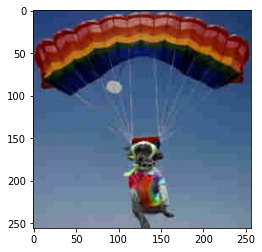

In [38]:
compressed = JPEGCompress(image, torch.round(y_table), torch.round(c_table))[1]
plt.imshow(transforms.ToPILImage()(compressed))

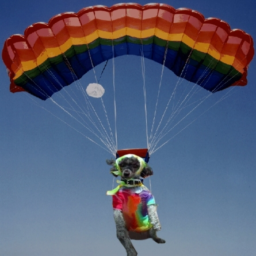

In [36]:
transforms.ToPILImage()(image[1])

In [39]:
torch.save({"y_table" : y_table,
           "c_table" : c_table,
            "optimizer" : optimizer.state_dict(),
           }, "best_ckpt.tar")

In [40]:
t = torch.load("best_ckpt.tar")
t

{'y_table': tensor([[  2,   1,   2,   2,   1,   1,   2,   2],
         [  2,   2,   2,   2,   2,   2,   2, 255],
         [  2,   2,   2,   2,   2,   2, 255, 255],
         [  2,   2,   2,   2,   2, 255, 255, 255],
         [  2,   2,   2,   2,   2, 255, 255, 255],
         [  2,   2,   2,   2,   2,   2, 255, 255],
         [  2,   2, 255,   2, 255, 255, 255, 255],
         [  2, 255, 255, 255, 255, 255, 255, 255]]),
 'c_table': tensor([[  2,   2,   2, 255, 255, 255, 255, 255],
         [  2,   2,   2, 255, 255, 255, 255, 255],
         [  2,   2, 255, 255, 255, 255, 255, 255],
         [  2, 255, 255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255]]),
 'optimizer': {'state': {0: {'step': tensor(100.),
    'mu_product': tensor(4.7370e-35),
    'exp_avg': tensor([[[ 1.0105e-04, -2.0898e-03, -2.5271e-05,  ...,